Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_estimators=200; 

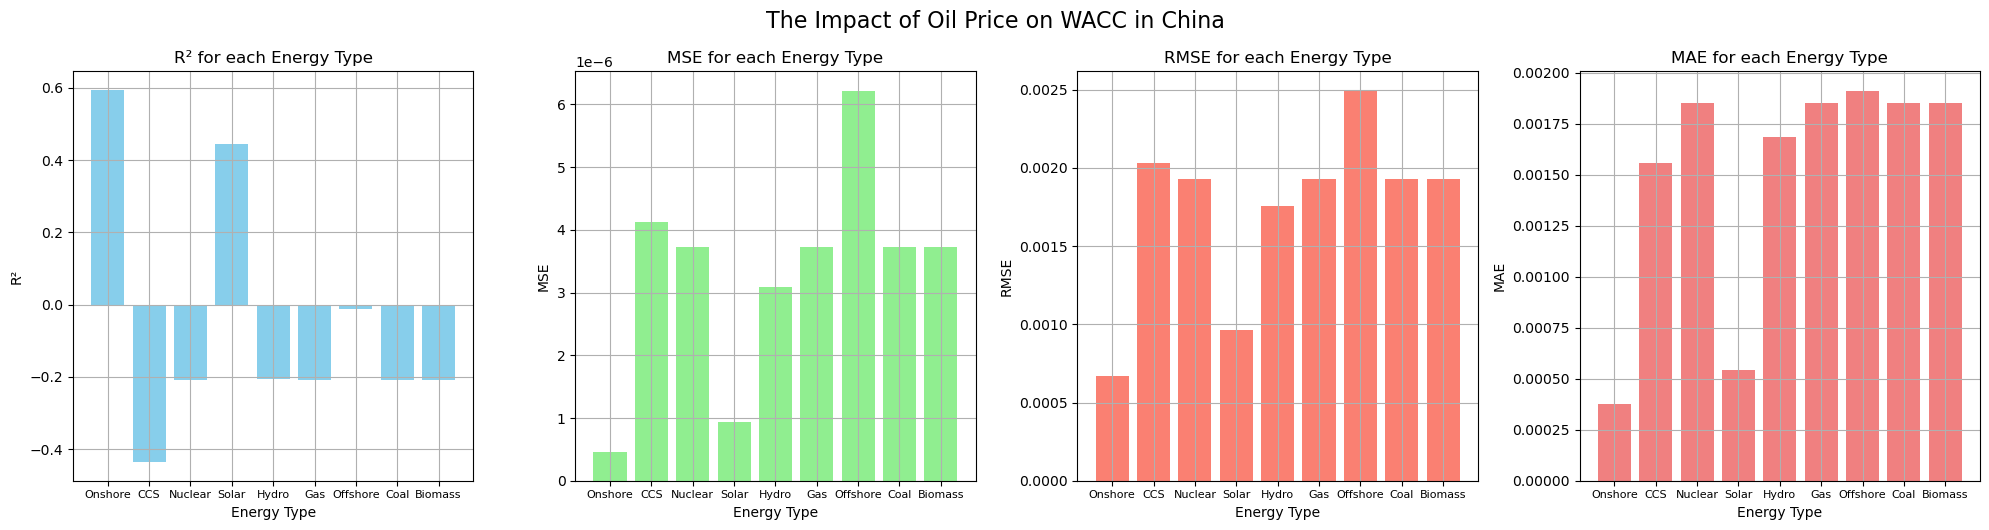

  Energy Type        R²           MSE      RMSE       MAE  \
0     Onshore  0.593951  4.510743e-07  0.000672  0.000378   
1         CCS -0.435931  4.132487e-06  0.002033  0.001559   
2     Nuclear -0.208177  3.729017e-06  0.001931  0.001853   
3       Solar  0.443823  9.306974e-07  0.000965  0.000543   
4       Hydro -0.206058  3.092635e-06  0.001759  0.001687   
5         Gas -0.208177  3.729017e-06  0.001931  0.001853   
6    Offshore -0.012918  6.217360e-06  0.002493  0.001912   
7        Coal -0.208177  3.729017e-06  0.001931  0.001853   
8     Biomass -0.208177  3.729017e-06  0.001931  0.001853   

                                          Best Model  
0  ([DecisionTreeRegressor(criterion='friedman_ms...  
1  ([DecisionTreeRegressor(criterion='friedman_ms...  
2  ([DecisionTreeRegressor(criterion='friedman_ms...  
3  ([DecisionTreeRegressor(criterion='friedman_ms...  
4  ([DecisionTreeRegressor(criterion='friedman_ms...  
5  ([DecisionTreeRegressor(criterion='friedman_ms...  
6  (

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Load data
df = pd.read_excel('China+_WACC_And_Predicted_Price.xlsx', sheet_name='Sheet1')

# Ensure the dataframe has a 'Year' column and that it's sorted by year (optional but good practice for time series)
df = df.sort_values('Year')

# Define the energy types
energy_types = ['Onshore', 'CCS', 'Nuclear', 'Solar', 'Hydro', 'Gas', 'Offshore', 'Coal', 'Biomass']

# Store regression results and model evaluation metrics
results = []

# Build models for each energy type
for energy in energy_types:
    X = df[['Oil_Price']]  # Feature: Oil_Price
    y = df[energy]         # Target: WACC for each energy type

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize the GradientBoostingRegressor model
    gb_model = GradientBoostingRegressor(random_state=42)

    # Define the parameter distribution for RandomizedSearchCV
    param_dist = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 9],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # Perform randomized search for hyperparameter tuning
    random_search = RandomizedSearchCV(gb_model, param_distributions=param_dist, n_iter=50, cv=5,
                                       scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)

    # Predict using the best model from the random search
    y_pred = random_search.best_estimator_.predict(X_test)
    
    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store results
    results.append({
        'Energy Type': energy,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'Best Model': random_search.best_estimator_
    })

# Convert results to DataFrame for easier visualization
results_df = pd.DataFrame(results)

# Plot the evaluation metrics for each energy type
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# Plot R² values
ax[0].bar(results_df['Energy Type'], results_df['R²'], color='skyblue')
ax[0].set_title('R² for each Energy Type')
ax[0].set_xlabel('Energy Type')
ax[0].set_ylabel('R²')
ax[0].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[0].grid(True)

# Plot MSE values
ax[1].bar(results_df['Energy Type'], results_df['MSE'], color='lightgreen')
ax[1].set_title('MSE for each Energy Type')
ax[1].set_xlabel('Energy Type')
ax[1].set_ylabel('MSE')
ax[1].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[1].grid(True)

# Plot RMSE values
ax[2].bar(results_df['Energy Type'], results_df['RMSE'], color='salmon')
ax[2].set_title('RMSE for each Energy Type')
ax[2].set_xlabel('Energy Type')
ax[2].set_ylabel('RMSE')
ax[2].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[2].grid(True)

# Plot MAE values
ax[3].bar(results_df['Energy Type'], results_df['MAE'], color='lightcoral')
ax[3].set_title('MAE for each Energy Type')
ax[3].set_xlabel('Energy Type')
ax[3].set_ylabel('MAE')
ax[3].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[3].grid(True)

# Adjust layout for better presentation
plt.tight_layout()

# Add the main title for the whole figure
plt.suptitle('The Impact of Oil Price on WACC in China', fontsize=16, y=1.05)

# Save the plot as an image file (PNG format)
plt.savefig('The_Impact_of_Oil_Price_on_WACC_in_China.png', dpi=300)

# Show the plot
plt.show()

# Print evaluation results for each energy type
print(results_df)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.2, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=4, min_samples_split=5, n_estimators=100; to

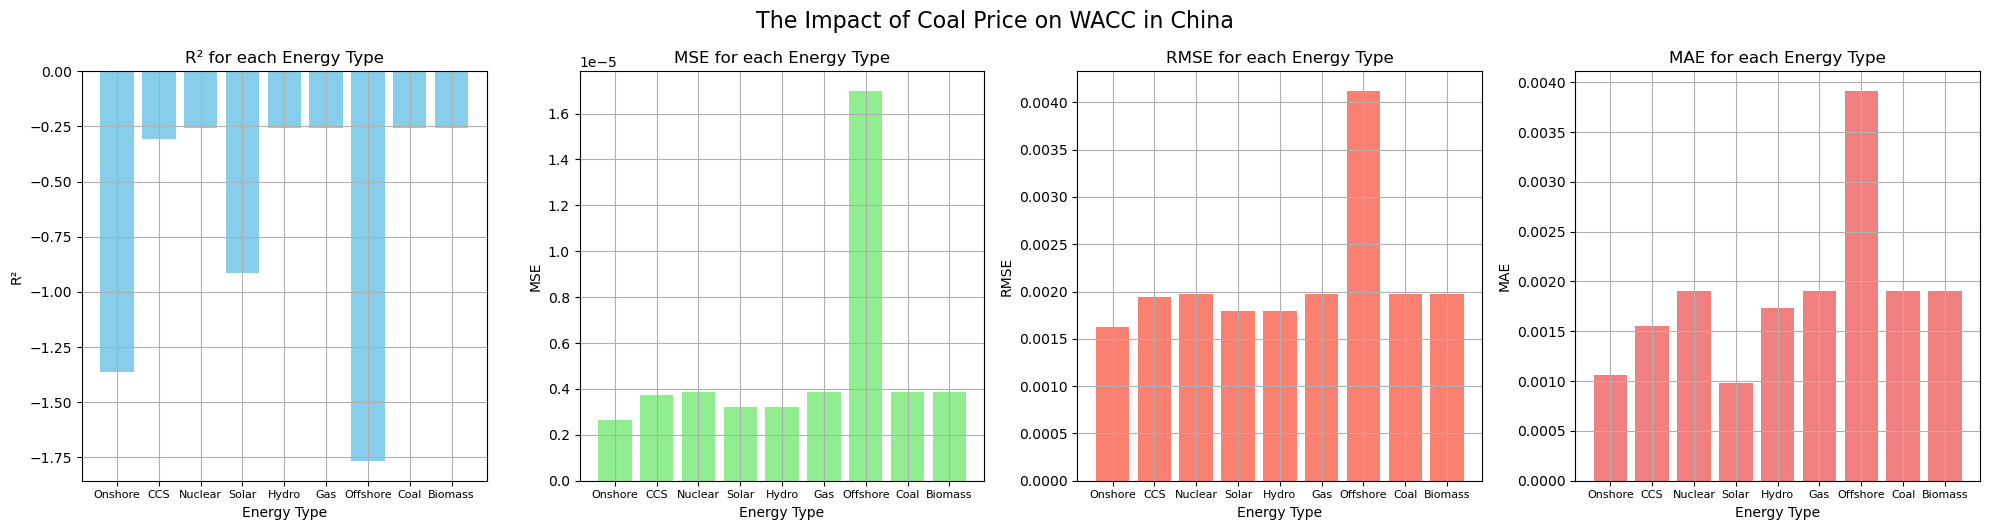

  Energy Type        R²       MSE      RMSE       MAE  \
0     Onshore -1.362180  0.000003  0.001620  0.001059   
1         CCS -0.305086  0.000004  0.001938  0.001550   
2     Nuclear -0.256448  0.000004  0.001969  0.001904   
3       Solar -0.913995  0.000003  0.001790  0.000984   
4       Hydro -0.256691  0.000003  0.001795  0.001735   
5         Gas -0.256448  0.000004  0.001969  0.001904   
6    Offshore -1.767672  0.000017  0.004122  0.003914   
7        Coal -0.256448  0.000004  0.001969  0.001904   
8     Biomass -0.256448  0.000004  0.001969  0.001904   

                                          Best Model  
0  ([DecisionTreeRegressor(criterion='friedman_ms...  
1  ([DecisionTreeRegressor(criterion='friedman_ms...  
2  ([DecisionTreeRegressor(criterion='friedman_ms...  
3  ([DecisionTreeRegressor(criterion='friedman_ms...  
4  ([DecisionTreeRegressor(criterion='friedman_ms...  
5  ([DecisionTreeRegressor(criterion='friedman_ms...  
6  ([DecisionTreeRegressor(criterion='friedm

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Load data
df = pd.read_excel('China+_WACC_And_Predicted_Price.xlsx', sheet_name='Sheet1')

# Ensure the dataframe has a 'Year' column and that it's sorted by year (optional but good practice for time series)
df = df.sort_values('Year')

# Define the energy types
energy_types = ['Onshore', 'CCS', 'Nuclear', 'Solar', 'Hydro', 'Gas', 'Offshore', 'Coal', 'Biomass']

# Store regression results and model evaluation metrics
results = []

# Build models for each energy type
for energy in energy_types:
    X = df[['Coal_Price']]  # Feature: Coal_Price
    y = df[energy]         # Target: WACC for each energy type

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize the GradientBoostingRegressor model
    gb_model = GradientBoostingRegressor(random_state=42)

    # Define the parameter distribution for RandomizedSearchCV
    param_dist = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 9],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # Perform randomized search for hyperparameter tuning
    random_search = RandomizedSearchCV(gb_model, param_distributions=param_dist, n_iter=50, cv=5,
                                       scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)

    # Predict using the best model from the random search
    y_pred = random_search.best_estimator_.predict(X_test)
    
    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store results
    results.append({
        'Energy Type': energy,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'Best Model': random_search.best_estimator_
    })

# Convert results to DataFrame for easier visualization
results_df = pd.DataFrame(results)

# Plot the evaluation metrics for each energy type
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# Plot R² values
ax[0].bar(results_df['Energy Type'], results_df['R²'], color='skyblue')
ax[0].set_title('R² for each Energy Type')
ax[0].set_xlabel('Energy Type')
ax[0].set_ylabel('R²')
ax[0].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[0].grid(True)

# Plot MSE values
ax[1].bar(results_df['Energy Type'], results_df['MSE'], color='lightgreen')
ax[1].set_title('MSE for each Energy Type')
ax[1].set_xlabel('Energy Type')
ax[1].set_ylabel('MSE')
ax[1].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[1].grid(True)

# Plot RMSE values
ax[2].bar(results_df['Energy Type'], results_df['RMSE'], color='salmon')
ax[2].set_title('RMSE for each Energy Type')
ax[2].set_xlabel('Energy Type')
ax[2].set_ylabel('RMSE')
ax[2].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[2].grid(True)

# Plot MAE values
ax[3].bar(results_df['Energy Type'], results_df['MAE'], color='lightcoral')
ax[3].set_title('MAE for each Energy Type')
ax[3].set_xlabel('Energy Type')
ax[3].set_ylabel('MAE')
ax[3].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[3].grid(True)

# Adjust layout for better presentation
plt.tight_layout()

# Add the main title for the whole figure
plt.suptitle('The Impact of Coal Price on WACC in China', fontsize=16, y=1.05)

# Save the plot as an image file (PNG format)
plt.savefig('The_Impact_of_Coal_Price_on_WACC_in_China.png', dpi=300)

# Show the plot
plt.show()

# Print evaluation results for each energy type
print(results_df)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.2, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, min_samples_leaf=4, min_samples_split=5, n_estimators=100; 

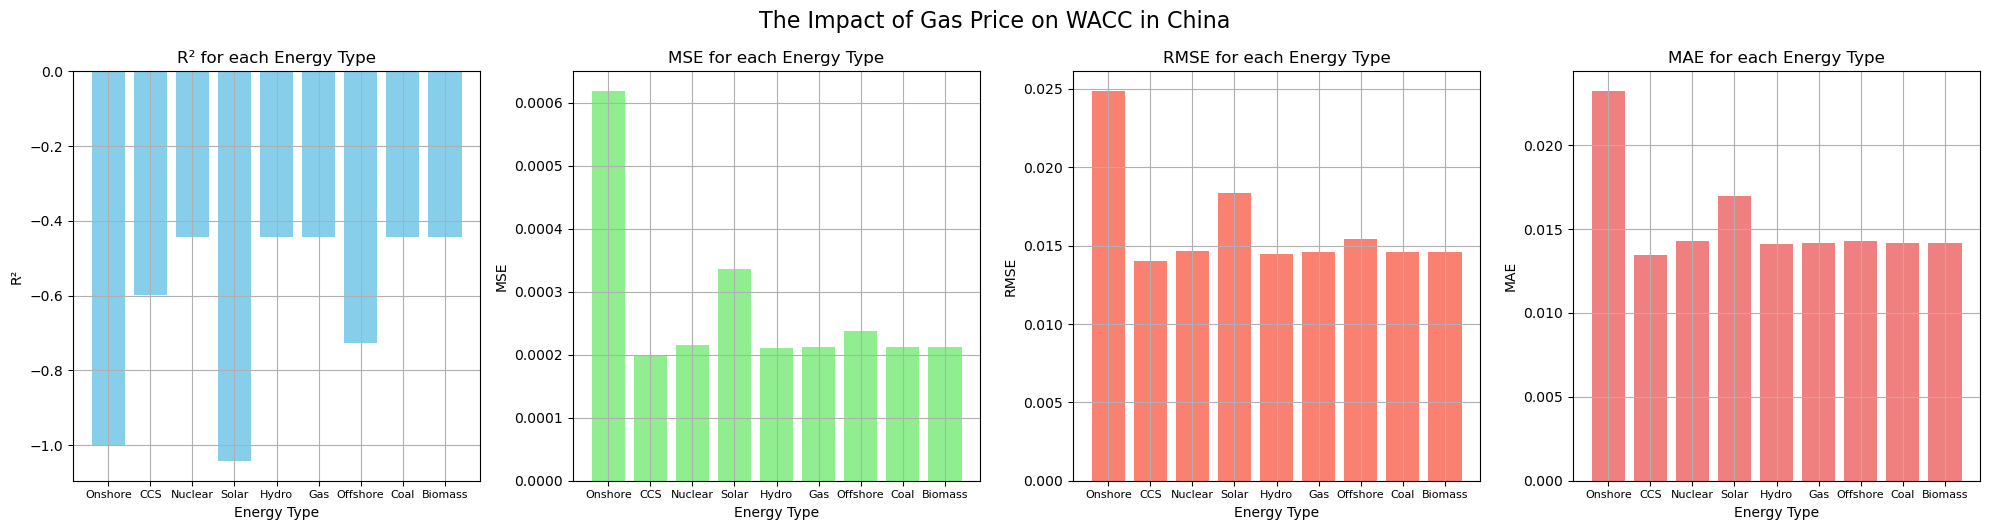

  Energy Type        R²       MSE      RMSE       MAE  \
0     Onshore -0.999475  0.000619  0.024881  0.023236   
1         CCS -0.597388  0.000197  0.014045  0.013431   
2     Nuclear -0.443634  0.000215  0.014678  0.014263   
3       Solar -1.042651  0.000336  0.018332  0.016989   
4       Hydro -0.443794  0.000210  0.014492  0.014081   
5         Gas -0.443697  0.000213  0.014589  0.014176   
6    Offshore -0.727399  0.000237  0.015394  0.014286   
7        Coal -0.443697  0.000213  0.014589  0.014176   
8     Biomass -0.443697  0.000213  0.014589  0.014176   

                                          Best Model  
0  ([DecisionTreeRegressor(criterion='friedman_ms...  
1  ([DecisionTreeRegressor(criterion='friedman_ms...  
2  ([DecisionTreeRegressor(criterion='friedman_ms...  
3  ([DecisionTreeRegressor(criterion='friedman_ms...  
4  ([DecisionTreeRegressor(criterion='friedman_ms...  
5  ([DecisionTreeRegressor(criterion='friedman_ms...  
6  ([DecisionTreeRegressor(criterion='friedm

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Load data
df = pd.read_excel('Meadle_EAST_WACC_And_Predicted_Price.xlsx', sheet_name='Sheet1')

# Ensure the dataframe has a 'Year' column and that it's sorted by year (optional but good practice for time series)
df = df.sort_values('Year')

# Define the energy types
energy_types = ['Onshore', 'CCS', 'Nuclear', 'Solar', 'Hydro', 'Gas', 'Offshore', 'Coal', 'Biomass']

# Store regression results and model evaluation metrics
results = []

# Build models for each energy type
for energy in energy_types:
    X = df[['Gas_Price']]  # Feature: Coal_Price
    y = df[energy]         # Target: WACC for each energy type

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize the GradientBoostingRegressor model
    gb_model = GradientBoostingRegressor(random_state=42)

    # Define the parameter distribution for RandomizedSearchCV
    param_dist = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 9],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # Perform randomized search for hyperparameter tuning
    random_search = RandomizedSearchCV(gb_model, param_distributions=param_dist, n_iter=50, cv=5,
                                       scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)

    # Predict using the best model from the random search
    y_pred = random_search.best_estimator_.predict(X_test)
    
    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store results
    results.append({
        'Energy Type': energy,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'Best Model': random_search.best_estimator_
    })

# Convert results to DataFrame for easier visualization
results_df = pd.DataFrame(results)

# Plot the evaluation metrics for each energy type
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# Plot R² values
ax[0].bar(results_df['Energy Type'], results_df['R²'], color='skyblue')
ax[0].set_title('R² for each Energy Type')
ax[0].set_xlabel('Energy Type')
ax[0].set_ylabel('R²')
ax[0].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[0].grid(True)

# Plot MSE values
ax[1].bar(results_df['Energy Type'], results_df['MSE'], color='lightgreen')
ax[1].set_title('MSE for each Energy Type')
ax[1].set_xlabel('Energy Type')
ax[1].set_ylabel('MSE')
ax[1].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[1].grid(True)

# Plot RMSE values
ax[2].bar(results_df['Energy Type'], results_df['RMSE'], color='salmon')
ax[2].set_title('RMSE for each Energy Type')
ax[2].set_xlabel('Energy Type')
ax[2].set_ylabel('RMSE')
ax[2].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[2].grid(True)

# Plot MAE values
ax[3].bar(results_df['Energy Type'], results_df['MAE'], color='lightcoral')
ax[3].set_title('MAE for each Energy Type')
ax[3].set_xlabel('Energy Type')
ax[3].set_ylabel('MAE')
ax[3].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[3].grid(True)

# Adjust layout for better presentation
plt.tight_layout()

# Add the main title for the whole figure
plt.suptitle('The Impact of Gas Price on WACC in China', fontsize=16, y=1.05)

# Save the plot as an image file (PNG format)
plt.savefig('The_Impact_of_Gas_Price_on_WACC_in_China.png', dpi=300)

# Show the plot
plt.show()

# Print evaluation results for each energy type
print(results_df)
